# Load and Process Graph Data

In this session, you will learn:

* Load graph data stored in CSV files.
* Construct a graph in DGL.
* Query structural information of a DGL graph.
* Load and pre-process node and edge features.
* Assign features for message passing

## Load graph data from CSV

Comma Separated Values (CSV) is a widely-used format for storing relational data. In this tutorial, we have prepared two CSV files that store [the Zachery's Karate Club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).
* The `nodes.csv` stores every club members and their attributes.
* The `edges.csv` stores the pair-wise interactions between two club members.

In [ ]:
!ls -lh '../../dataset/karate'

total 12K
-rw-r--r-- 1 ki ki 3.8K Nov 16 08:26 edges.csv
-rw-r--r-- 1 ki ki 1.3K Nov 16 08:54 gen_data.py
-rw-r--r-- 1 ki ki  461 Nov 16 08:26 nodes.csv


We can use `pandas` to load the two CSV files.

In [ ]:
import pandas as pd

nodes_data = pd.read_csv('../../dataset/karate/nodes.csv')
print(nodes_data)

    Id     Club  Age
0    0   Mr. Hi   45
1    1   Mr. Hi   33
2    2   Mr. Hi   36
3    3   Mr. Hi   31
4    4   Mr. Hi   41
5    5   Mr. Hi   42
6    6   Mr. Hi   48
7    7   Mr. Hi   41
8    8   Mr. Hi   30
9    9  Officer   35
10  10   Mr. Hi   38
11  11   Mr. Hi   44
12  12   Mr. Hi   37
13  13   Mr. Hi   39
14  14  Officer   36
15  15  Officer   38
16  16   Mr. Hi   47
17  17   Mr. Hi   45
18  18  Officer   41
19  19   Mr. Hi   31
20  20  Officer   31
21  21   Mr. Hi   44
22  22  Officer   42
23  23  Officer   32
24  24  Officer   30
25  25  Officer   50
26  26  Officer   30
27  27  Officer   43
28  28  Officer   48
29  29  Officer   40
30  30  Officer   39
31  31  Officer   45
32  32  Officer   47
33  33  Officer   33


In [ ]:
edges_data = pd.read_csv('../../dataset/karate/edges.csv')
print(edges_data)

     Src  Dst    Weight
0      0    1  0.318451
1      0    2  0.551215
2      0    3  0.227416
3      0    4  0.266919
4      0    5  0.475449
..   ...  ...       ...
151   33   28  0.266479
152   33   29  0.279901
153   33   30  0.652154
154   33   31  0.828536
155   33   32  0.842656

[156 rows x 3 columns]


We then construct a graph where each node is a club member and each edge represents their interactions. In DGL, **nodes are consecutive integers starting from zero**. Thus, when preparing the data, it is important to re-label or re-shuffle the row order so that the first row corresponding to the first nodes, so on and so forth.

In this example, we have already prepared the data in the correct order, so we can create the graph by the `'Src'` and `'Dst'` columns from the `edges.csv` table.

In [ ]:
import dgl

src = edges_data['Src'].to_numpy()
dst = edges_data['Dst'].to_numpy()

# Create a DGL graph from a pair of numpy arrays
g = dgl.graph((src, dst))

# Print a graph gives some meta information such as number of nodes and edges.
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})


A DGL graph can be converted to a `networkx` graph, so to utilize its rich functionalities such as visualization.

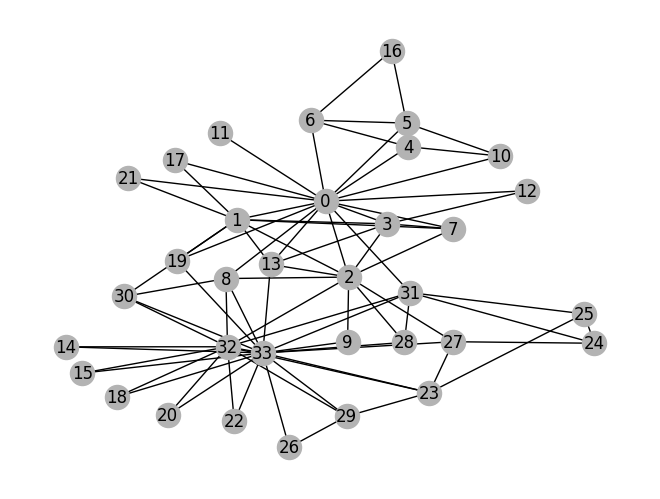

In [ ]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_g = g.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, node_color=[[.7, .7, .7]])

## Query graph structures

Let's print out how many nodes and edges are there in this graph.

In [ ]:
print('#Nodes', g.number_of_nodes())
print('#Edges', g.number_of_edges())

#Nodes 34
#Edges 156


We can also perform queries on the graph structures.

Get the in-degree of node 0:

In [ ]:
g.in_degree(0)

/home/ki/repos/dgl2/venv/lib/python3.10/site-packages/dgl/heterograph.py:3432: DGLWarning: DGLGraph.in_degree is deprecated. Please use DGLGraph.in_degrees
  dgl_warning("DGLGraph.in_degree is deprecated. Please use DGLGraph.in_degrees")


16

Get the successors of node 0:

In [ ]:
g.successors(0)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

DGL provides APIs for querying structural information. See the API document [here](https://docs.dgl.ai/api/python/heterograph.html#querying-graph-structure).

![image.png](https://github.com/karpovilia/dgl_temp/blob/main/src/01.%20Basics/images/dgl-query.png?raw=1)

## Load node and edge features

In many graph data, nodes and edges have attributes. Although these attributes can have arbitrary types, a DGL graph only accepts attributes stored in tensors (with numerical contents). The vast development of deep learning has provided us many ways to vectorize various types of attributes into numerical features. Here are some general suggestions:
* For categorical attributes (e.g. gender, occupation), consider converting them to integers or one-hot encoding.
* For variable length string contents (e.g. news article, quote), consider applying a language model.
* For images, consider applying a vision model such as CNNs.

Our data set has the following attribute columns:
* `Age` is already an integer attribute.
* `Club` is a categorical attribute representing which community each member belongs to.
* `Weight` is a floating number indicating the strength of each interaction.

In [ ]:
import torch

# Prepare the age node feature
age = torch.tensor(nodes_data['Age'].to_numpy()).float() / 100
print(age)

tensor([0.4500, 0.3300, 0.3600, 0.3100, 0.4100, 0.4200, 0.4800, 0.4100, 0.3000,
        0.3500, 0.3800, 0.4400, 0.3700, 0.3900, 0.3600, 0.3800, 0.4700, 0.4500,
        0.4100, 0.3100, 0.3100, 0.4400, 0.4200, 0.3200, 0.3000, 0.5000, 0.3000,
        0.4300, 0.4800, 0.4000, 0.3900, 0.4500, 0.4700, 0.3300])


In [ ]:
# Get the features of node 0 and 10
age[[0, 10]]

tensor([0.4500, 0.3800])

Use `g.ndata` to set the age features to the graph.

In [ ]:
# Feed the features to graph
g.ndata['age'] = age
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64), 'age': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={})


In [ ]:
# The "Club" column represents which community does each node belong to.
# The values are of string type, so we must convert it to either categorical
# integer values or one-hot encoding.

club = nodes_data['Club'].to_list()
# Convert to categorical integer values with 0 for 'Mr. Hi', 1 for 'Officer'.
club = torch.tensor([c == 'Officer' for c in club]).long()

# We can also convert it to one-hot encoding.
club_onehot = torch.nn.functional.one_hot(club)
print(club_onehot)

# Use `g.ndata` like a normal dictionary
g.ndata.update({'club' : club, 'club_onehot' : club_onehot})
# Remove some features using del
del g.ndata['age']

print(g)

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])
Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


Feeding edge features to a DGL graph is similar.

In [ ]:
# Get edge features from the DataFrame and feed it to graph.
edge_weight = torch.tensor(edges_data['Weight'].to_numpy())
# Similarly, use `g.edata` for getting/setting edge features.
g.edata['weight'] = edge_weight
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


In [ ]:
# Assign a random 4d features to srcdata, and 7d features to dstdata
g.srcdata['src_h'] = torch.randn(34,4)
g.dstdata['dst_h'] = torch.randn(34,7)

print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64), 'src_h': Scheme(shape=(4,), dtype=torch.float32), 'dst_h': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


In the graph `g`, the two node features are stored in ndata_schema. We can query these two features via `ndata` directly.

In [ ]:
print(g.ndata['src_h'])

tensor([[-0.9939,  2.3482,  0.4566, -0.5814],
        [-0.1365,  0.3217, -0.5298, -0.8264],
        [-1.9704,  1.8314,  1.1045, -0.9595],
        [-0.7427,  0.9603, -0.5527,  0.6198],
        [ 1.7204,  0.3748,  0.2190,  0.3180],
        [ 0.7588, -2.1265, -0.1758,  1.0318],
        [ 1.4346, -0.5961, -0.0390, -0.3148],
        [-0.4335, -0.4467,  1.5008,  0.6296],
        [-2.2904,  0.5893, -0.5519, -0.0487],
        [-0.6225,  0.4134,  0.4311, -0.8613],
        [-0.3371,  0.4286,  1.3371, -0.7598],
        [-0.0159, -2.0252,  1.6871, -0.2571],
        [-0.6281, -1.7768,  1.8742, -2.0560],
        [-0.9424,  2.5966, -1.1498,  0.0709],
        [ 1.4918, -0.3698, -0.0627,  0.8293],
        [-1.8742, -0.2072, -1.0412,  1.4942],
        [ 0.8928,  0.1302, -0.4742, -0.2830],
        [ 0.1554, -0.3505,  1.6249,  0.5786],
        [ 0.6816,  0.2258, -1.2991,  0.9403],
        [-0.4100,  1.7619,  0.4248,  0.0982],
        [ 0.0801,  0.7462,  0.5747,  1.1392],
        [ 0.6823, -0.1935, -0.2531

In the heterogenous graph case, nodes in different relations become either source nodes or destination. Then `srcdata` and `dstdata` are specifically stored to these two types of nodes. For more details about heterogenous graphs, users can refer [DGL User Guide 1.5 Heterogeneous Graphs](https://docs.dgl.ai/guide/graph-heterogeneous.html#guide-graph-heterogeneous)

In [ ]:
# Create a heterograph with 3 node types and 3 edges types.
heterograph_data = {
   ('drug', 'interacts', 'drug'): (torch.tensor([0, 1]), torch.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (torch.tensor([0, 1]), torch.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (torch.tensor([1]), torch.tensor([2]))
}
hetero_g = dgl.heterograph(heterograph_data)
print(hetero_g)

In [ ]:
# Extract one relation 'durg->interacts->gene' out
sub_g = dgl.edge_type_subgraph(hetero_g, [('drug', 'interacts', 'gene')])
print(sub_g)

In [ ]:
# Assign features to source and destination nodes. Note that the number of drug nodes and gene nodes are different
sub_g.srcdata['src_h'] = torch.randn(3,3)
sub_g.dstdata['dst_h'] = torch.randn(4,2)
print(sub_g)

More about the usage of `srcdata` and `dstdata` could be found in the 5_message_passing and tutorials at the large graph tasks.